# Problem

As a Series A company, achieving and demonstrating consistent, predictable revenue growth is crucial. High churn rates directly undermine this by eroding the customer base and revenue.

Knowing which customers are more likely to churn allows for smarter allocation of support and service resources.
Prioritizing high-risk customers with tailored engagement can improve retention rates effectively.



# Classification model


Gradient boosting is a machine learning technique commonly used for binary classification tasks like churn prediction. It builds a predictive model in a stage-wise fashion and is optimized for a binary classification loss function.

**Basic Idea for Binary Classification**:
- Aim: Predict whether a customer will churn (1) or not (0).
- Combine several weak predictive models (typically decision trees) to create a strong predictive model.

**xgBoost explained**:
- Each decision tree in the ensemble focuses on the customers that previous trees predicted incorrectly.
- The loss function typically used is the logistic loss, which is suitable for binary outcomes.
- Regularization techniques (like controlling the number of trees, tree depth, and learning rate) are crucial to avoid overfitting.
- The output can be transformed into a probability of churn using the logistic function.

**Algorithm**:
1. Initialize the model with a constant value:
   $$ F_0(x) = \arg\min_{\gamma} \sum_{i=1}^{N} L(y_i, \gamma) $$
   where $F_0$ is the initial model, $L$ is the binary classification loss function (like logistic loss), $y_i$ are the true binary labels, and $N$ is the number of data points.

2. For each stage $m = 1$ to $M$ (where $M$ is the number of boosting stages):
   a. Compute the negative gradient (pseudo-residuals) for the binary classification loss function:
      $$ r_{im} = -\left[ \frac{\partial L(y_i, F(x_i))}{\partial F(x_i)} \right]_{F(x)=F_{m-1}(x)} \quad \text{for } i=1,2,\dots,N $$
   b. Fit a weak learner (e.g., a decision tree) to these pseudo-residuals.
   c. Compute the multiplier $\gamma_m$ for the weak learner by solving:
      $$ \gamma_m = \arg\min_{\gamma} \sum_{i=1}^{N} L(y_i, F_{m-1}(x_i) + \gamma h_m(x_i)) $$
      where $h_m(x_i)$ is the weak learner.
   d. Update the model:
      $$ F_m(x) = F_{m-1}(x) + \gamma_m h_m(x) $$

3. The final model is:
   $$ F_M(x) = F_0(x) + \sum_{m=1}^{M} \gamma_m h_m(x) $$



# Data required

### $y$-variable
- Churn status [bool]


### $x$-variables

**Billing information**
- Product [str]
- Annual billing cadence [bool]
- Seats [int]
- % Expansion [float]
- Duration (current if live, until churn date if churned) [int]

**Product RFM data**
- Frequency [float] (average count per day): Projects, Transcriptions, Notes, Highlights, Tags, Comments, Invites, Shared Objects, Reels, Reel Views
- Recency [int] (days since last activity): Projects, Transcriptions, Notes, Highlights, Tags, Comments, Invites, Shared Objects, Reels, Reel Views
- MRR [float]

Recency and frequency data should sample a specific period.

*Monthly Customers:* 
- If churned, converted date to churn date - 15 days
- If retained, converted date to min(current_date, next renewal date - 15 days)


$$\text{Data period starts}_m = \text{Conversion date}_m$$
$$\text{Data period ends}_m = \min(\text{Current date}, \text{Next renewal date - 15}_m)$$

*Monthly Customers:* 
- If churned, converted date to churn date - 90 days
- If retained, converted date to min(current_date, next renewal date - 90 days)


$$\text{Data period starts}_a = \text{Conversion date}_a$$
$$\text{Data period ends}_a = \min(\text{Current date}, \text{Next renewal date - 90}_a)$$

### Additional features
- ID
- Name
- Next billing date (if applicable)

# Import

In [43]:
def import_data_local_csv():
    import pandas as pd
    file_path = '/Users/patricksweeney/growth/04_Retention/04_Nonparametric churn prediction/Retention training.csv'
    data = pd.read_csv(file_path)
    return data

In [60]:
def drop_variables(data, variables):
    # Ensure 'variables' is a list
    if not isinstance(variables, list):
        raise ValueError("The 'variables' parameter should be a list of column names.")

    # Drop the specified columns
    data = data.drop(columns=variables, errors='ignore')

    return data


# Check data

In [44]:
def find_missing_values(data):
    missing_values = data.isnull().sum()
    print("Features with missing values are...")
    print(missing_values)

In [45]:
def impute_missing_values(data):
    import numpy as np
    import pandas as pd
    from sklearn.impute import SimpleImputer

    # Create an imputer instance with median strategy
    imputer = SimpleImputer(strategy='median')

    # Extract numerical columns
    data_num = data.select_dtypes(include=[np.number])

    # Fit the imputer to the numerical data
    imputer.fit(data_num)

    # Transform the numerical data with the imputer
    data_num_imputed = imputer.transform(data_num)

    # Convert the imputed data back to a DataFrame
    data_num_imputed_df = pd.DataFrame(data_num_imputed, columns=data_num.columns)

    # Replace the original numerical columns with the imputed ones
    data[data_num.columns] = data_num_imputed_df

    return data

# Feature engineering

In [46]:
def one_hot_encode(data, variables):
    import pandas as pd
    # Check if the input is a list of variables. If not, convert it to a list
    if not isinstance(variables, list):
        variables = [variables]
    # Perform one-hot encoding only on the specified variables
    for var in variables:
        if var in data.columns:
            # Get one-hot encoded dataframe with numeric type and drop the original column
            one_hot = pd.get_dummies(data[var], prefix=var, dtype=int)
            data = data.drop(var, axis=1)
            data = data.join(one_hot)
    return data

# Variables to one-hot encode
variables_to_encode = ['product', 'annual']


# Train and test Gradient Boosting

In [47]:
def gradient_boosting(data, y_variable):
    from sklearn.ensemble import GradientBoostingClassifier
    from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
    from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, cohen_kappa_score, brier_score_loss
    from sklearn.calibration import calibration_curve
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    random_state = 1

    # Separate the features and target variable (also drop not numeric X features)
    X = data.drop(columns=[y_variable]).select_dtypes(include=np.number)
    y = data[y_variable]

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    # 1. Train model
    model = GradientBoostingClassifier()
    model.fit(X_train, y_train)

    # 2. Test model
    cv = StratifiedKFold(n_splits=10)
    cross_val_scores = cross_val_score(model, X, y, cv=cv)
    print("Cross-validation scores:", cross_val_scores)

    # Predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # 3. Calibration plot
    prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)
    plt.plot(prob_pred, prob_true, "s-")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("True Probability")
    plt.title("Calibration Plot")
    plt.show()

    # 4. Classification report
    print(classification_report(y_test, y_pred))

    # 5. Confusion matrix
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred))

    # 6. ROC and AUC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

    # 7. Precision recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

    # 8. Cross-validation score
    print("Average cross-validation score:", np.mean(cross_val_scores))

    # 11. Cohen's Kappa
    kappa = cohen_kappa_score(y_test, y_pred)
    print("Cohen's Kappa:", kappa)

    # 11.5 Brier Score
    brier_score = brier_score_loss(y_test, y_proba)
    print(f"Brier Score: {brier_score}")
    
    return model

# Save model

In [48]:
def save_model(model, filename):
    import joblib

    # Save the model
    joblib.dump(model, filename)

    import pickle
    with open(filename, 'wb') as file:
         pickle.dump(model, file)

# Return predictions

In [54]:
def get_predictions(data, model, y_variable):
    import pandas as pd
    import numpy as np

    # Filter data where churn equals 0
    churn_data = data[data[y_variable] == 0]

    # Separate the features and retain the index
    X_churn = churn_data.drop(columns=[y_variable]).select_dtypes(include=np.number)

    # Make predictions
    predictions = model.predict(X_churn)
    probabilities = model.predict_proba(X_churn)[:, 1]

    # Append predictions and probabilities to the original data
    data.loc[churn_data.index, 'Prediction'] = predictions
    data.loc[churn_data.index, 'Probability'] = probabilities

    # Calculate and append the 'value_at_risk' by multiplying MRR with Probability
    # Replace 'MRR' with the actual name of your MRR column in the data
    data.loc[churn_data.index, 'value_at_risk'] = data.loc[churn_data.index, 'mrr'] * 12 * data.loc[churn_data.index, 'Probability']

    return data


In [52]:
def save_predictions(predictions, filename):
    import pandas as pd

    # Ensure the filename ends with '.xlsx'
    if not filename.endswith('.xlsx'):
        filename += '.xlsx'

    # Save to Excel
    predictions.to_excel(filename, index=False)


# Main

Cross-validation scores: [0.91084695 0.92273403 0.91964286 0.91815476 0.94047619 0.93452381
 0.92113095 0.91815476 0.92410714 0.90625   ]


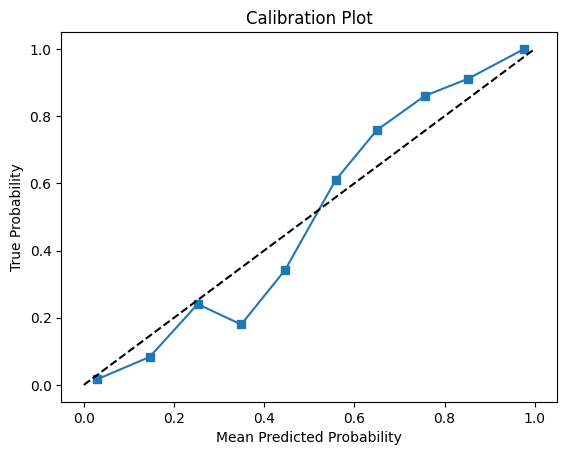

              precision    recall  f1-score   support

         0.0       0.93      0.96      0.94       814
         1.0       0.93      0.89      0.91       531

    accuracy                           0.93      1345
   macro avg       0.93      0.92      0.93      1345
weighted avg       0.93      0.93      0.93      1345

Confusion matrix:
[[781  33]
 [ 61 470]]


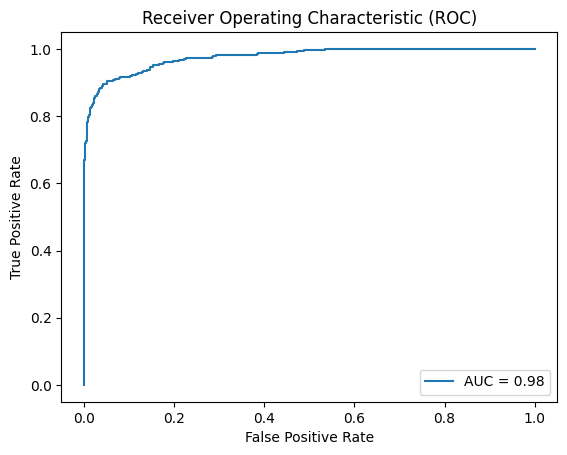

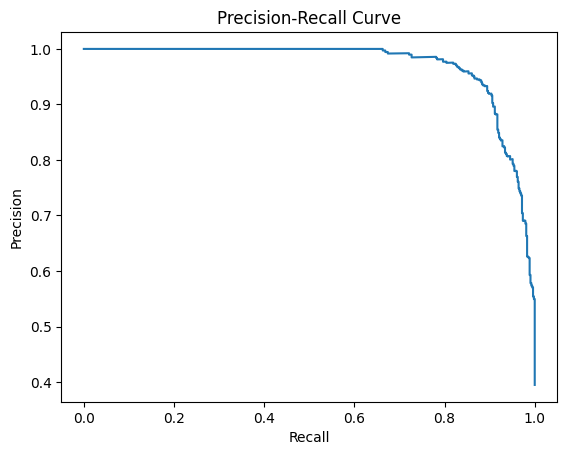

Average cross-validation score: 0.9216021456873984
Cohen's Kappa: 0.8523952067844734
Brier Score: 0.056588912488498795


In [61]:
#Import
data = import_data_local_csv()
data = drop_variables(data, ['t'])

#Preprocess
data = impute_missing_values(data)
data = one_hot_encode(data, variables_to_encode)

#Train and test
model = gradient_boosting(data, 'churned')

#Predict
predictions = get_predictions(data, model, 'churned')

#Save
save_model(model, 'gradient_boosting_churn.pkl')
save_predictions(predictions, 'predictions.xlsx')